### Project Goal
The goal of this project is to create a machine learning model to analyze and predict the value of Bitcoin using market data and market sentiment. Completed by following the tutorial from [here](https://www.youtube.com/watch?v=TF2Nx_ifmrU)

### Import Libraries


In [129]:
import requests
import time
import pandas as pd


Fetching the revision records from the Wikipedia page

In [130]:
BASE_URL = 'https://en.wikipedia.org/w/api.php'
headers = {'User-Agent': 'BitcoinPredictor/1.0 (riteshpersaud2003@gmail.com)'}


def fetch_bitcoin_revs():
    revs = []
    params = {
        'action': 'query', 'titles': 'Bitcoin', 'prop': 'revisions',
        'rvprop': 'timestamp|comment', 'rvslots': 'main', 'rvlimit': 500,
        'format': 'json', 'rvdir': 'older'
    }
    
    while True:
        resp = requests.get(BASE_URL, params=params, headers=headers)
        data = resp.json()
        
        if resp.status_code == 429:
            time.sleep(60)
            continue
            
        if 'continue' not in data: 
            break
            
        page = next(iter(data['query']['pages'].values()))
        revs.extend(page['revisions'])
        params['rvcontinue'] = data['continue']['rvcontinue']
        time.sleep(0.5)  
    
    return revs


revs = fetch_bitcoin_revs()
print(f"Total: {len(revs)} revisions")

Total: 18000 revisions


In [131]:
revs = sorted(revs, key=lambda x: x['timestamp'])
revs[0]

{'timestamp': '2010-07-21T03:22:25Z',
 'comment': 'Updated "Sites that accept Bitcoin"'}

In [132]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def find_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound'] 

In [133]:
edits = {}
for rev in revs:  # Already sorted oldest→newest
    date = pd.to_datetime(rev['timestamp']).strftime('%Y-%m-%d')
    if date not in edits:
        edits[date] = {'edit_count': 0, 'sentiments': []}
    edits[date]['edit_count'] += 1
    
    if rev.get('comment'):  # Skip empty comments
        score = analyzer.polarity_scores(rev['comment'][:250])
        edits[date]['sentiments'].append(score['compound'])  # -1 to +1

In [134]:
len(edits)

2787

In [135]:
from statistics import mean

for key in edits:
    if len(edits[key]['sentiments']) > 0:
        edits[key]['sentiment'] = mean(edits[key]['sentiments'])
        edits[key]["neg_sentiment"] = len([s for s in edits[key]['sentiments'] if s < 0]) / len(edits[key]['sentiments'])
    else:
        edits[key]['sentiment'] = 0
        edits[key]['neg_sentiment'] = 0

    del edits[key]['sentiments']  # Remove raw sentiments to save space

In [136]:
edits_df = pd.DataFrame.from_dict(edits, orient='index')

In [137]:
edits_df

,edit_count,sentiment,neg_sentiment
2010-07-21,16,0.195920,0.000000
2010-07-22,1,-0.648600,1.000000
2010-07-25,4,0.046867,0.333333
2010-07-29,3,0.000000,0.000000
2010-08-03,3,0.000000,0.000000
...,...,...,...
2025-12-25,1,0.000000,0.000000
2026-01-04,2,0.000000,0.000000
2026-01-05,2,0.041700,0.500000
2026-01-11,4,0.093975,0.000000


In [138]:
edits_df.index = pd.to_datetime(edits_df.index)

In [139]:
from datetime import datetime
dates = pd.date_range(start=edits_df.index.min(), end=datetime.today())

In [140]:
edits_df = edits_df.reindex(dates, fill_value=0)
edits_df

,edit_count,sentiment,neg_sentiment
2010-07-21,16,0.195920,0.000000
2010-07-22,1,-0.648600,1.000000
2010-07-23,0,0.000000,0.000000
2010-07-24,0,0.000000,0.000000
2010-07-25,4,0.046867,0.333333
...,...,...,...
2026-01-19,0,0.000000,0.000000
2026-01-20,0,0.000000,0.000000
2026-01-21,0,0.000000,0.000000
2026-01-22,0,0.000000,0.000000


In [141]:
rolling_edits = edits_df.rolling(30, min_periods=30).mean()

In [142]:
rolling_edits = rolling_edits.dropna()

In [143]:
rolling_edits

,edit_count,sentiment,neg_sentiment
2010-08-19,1.266667,-0.007008,0.077778
2010-08-20,0.733333,-0.013539,0.077778
2010-08-21,0.733333,0.008081,0.044444
2010-08-22,0.733333,0.008081,0.044444
2010-08-23,0.733333,0.008081,0.044444
...,...,...,...
2026-01-19,0.333333,0.004523,0.016667
2026-01-20,0.333333,0.004523,0.016667
2026-01-21,0.333333,0.004523,0.016667
2026-01-22,0.333333,0.004523,0.016667


In [144]:
rolling_edits.to_csv('bitcoin_wiki_edits.csv')

In [145]:
import yfinance as yf
import os

In [146]:
btc_data = yf.Ticker('BTC-USD').history(period="max")
btc_data

/Users/riteshpersaud/Desktop/ML/venv/lib/python3.14/site-packages/yfinance/scrapers/history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-19 00:00:00+00:00,93655.671875,93660.828125,92089.250000,92553.593750,39195241508,0.0,0.0
2026-01-20 00:00:00+00:00,92553.601562,92798.429688,87814.929688,88310.906250,53072968031,0.0,0.0
2026-01-21 00:00:00+00:00,88326.507812,90430.406250,87231.570312,89376.960938,56330422434,0.0,0.0


In [147]:
del btc_data["Dividends"]
del btc_data["Stock Splits"]

In [148]:
btc_data.columns = [column.lower() for column in btc_data.columns]
btc_data.index = pd.to_datetime(btc_data.index)

In [149]:
btc_data

,open,high,low,close,volume
Date,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2026-01-19 00:00:00+00:00,93655.671875,93660.828125,92089.250000,92553.593750,39195241508
2026-01-20 00:00:00+00:00,92553.601562,92798.429688,87814.929688,88310.906250,53072968031
2026-01-21 00:00:00+00:00,88326.507812,90430.406250,87231.570312,89376.960938,56330422434


<Axes: title={'center': 'Bitcoin Closing Prices Over Time'}, xlabel='Date'>

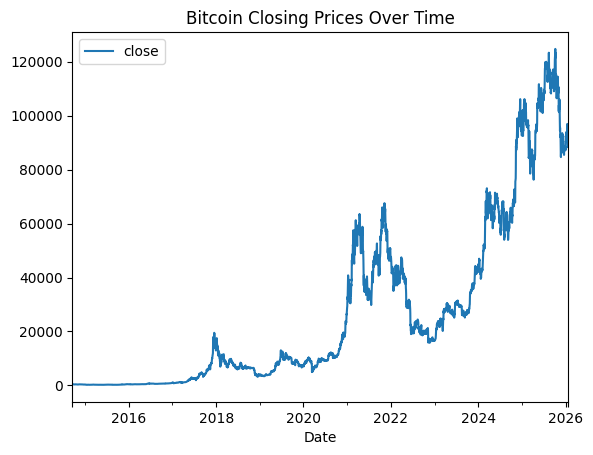

In [150]:

btc_data.plot.line(y='close', use_index=True, title='Bitcoin Closing Prices Over Time')

In [151]:
wiki_data = rolling_edits

wiki_data

,edit_count,sentiment,neg_sentiment
2010-08-19,1.266667,-0.007008,0.077778
2010-08-20,0.733333,-0.013539,0.077778
2010-08-21,0.733333,0.008081,0.044444
2010-08-22,0.733333,0.008081,0.044444
2010-08-23,0.733333,0.008081,0.044444
...,...,...,...
2026-01-19,0.333333,0.004523,0.016667
2026-01-20,0.333333,0.004523,0.016667
2026-01-21,0.333333,0.004523,0.016667
2026-01-22,0.333333,0.004523,0.016667


In [155]:
wiki_data.index = pd.to_datetime(wiki_data.index).tz_localize("UTC")

btc_data = btc_data.merge(wiki_data, left_index=True, right_index=True)

In [156]:
btc_data

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
Date,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,0.063883,0.050699
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,0.055104,0.067365
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,0.049084,0.084032
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,0.034718,0.084032
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,0.034718,0.084032
...,...,...,...,...,...,...,...,...
2026-01-19 00:00:00+00:00,93655.671875,93660.828125,92089.250000,92553.593750,39195241508,0.333333,0.004523,0.016667
2026-01-20 00:00:00+00:00,92553.601562,92798.429688,87814.929688,88310.906250,53072968031,0.333333,0.004523,0.016667
2026-01-21 00:00:00+00:00,88326.507812,90430.406250,87231.570312,89376.960938,56330422434,0.333333,0.004523,0.016667


In [157]:
btc_data["tomorrow"] = btc_data["close"].shift(-1)

In [158]:
btc_data

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow
Date,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,0.063883,0.050699,424.440002
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,0.055104,0.067365,394.795990
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,0.049084,0.084032,408.903992
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,0.034718,0.084032,398.821014
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,0.034718,0.084032,402.152008
...,...,...,...,...,...,...,...,...,...
2026-01-19 00:00:00+00:00,93655.671875,93660.828125,92089.250000,92553.593750,39195241508,0.333333,0.004523,0.016667,88310.906250
2026-01-20 00:00:00+00:00,92553.601562,92798.429688,87814.929688,88310.906250,53072968031,0.333333,0.004523,0.016667,89376.960938
2026-01-21 00:00:00+00:00,88326.507812,90430.406250,87231.570312,89376.960938,56330422434,0.333333,0.004523,0.016667,89462.453125


In [159]:
btc_data["target"] = (btc_data["tomorrow"] > btc_data["close"]).astype(int)

In [160]:
btc_data

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
Date,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,0.063883,0.050699,424.440002,0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,0.055104,0.067365,394.795990,0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,0.049084,0.084032,408.903992,1
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,0.034718,0.084032,398.821014,0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,0.034718,0.084032,402.152008,1
...,...,...,...,...,...,...,...,...,...,...
2026-01-19 00:00:00+00:00,93655.671875,93660.828125,92089.250000,92553.593750,39195241508,0.333333,0.004523,0.016667,88310.906250,0
2026-01-20 00:00:00+00:00,92553.601562,92798.429688,87814.929688,88310.906250,53072968031,0.333333,0.004523,0.016667,89376.960938,1
2026-01-21 00:00:00+00:00,88326.507812,90430.406250,87231.570312,89376.960938,56330422434,0.333333,0.004523,0.016667,89462.453125,1


In [164]:
btc_data["target"].value_counts()

target
1    2181
0    1966
Name: count, dtype: int64

### Creating a Baseline Model
This is a baseline model --> very simple model that we can use to get an idea of how the data is looking. A good baseline model is usually Random Forests because they generally speaking do not over fit the data as easily as some other models

In [165]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
train = btc_data.iloc[:-200]
test = btc_data.iloc[-200:]


features = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]

model.fit(train[features], train["target"])

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",50
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [166]:
from sklearn.metrics import precision_score

predictions = model.predict(test[features])
predictions = pd.Series(predictions, index=test.index)

precision = precision_score(test["target"], predictions)
precision

0.48936170212765956

In [168]:
def predict(training, test, predictors, model):
    model.fit(training[predictors], training["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [169]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:i+step].copy()
        
        preds = predict(train, test, predictors, model)
        all_predictions.append(preds)
    return pd.concat(all_predictions)

### Upgrading the Model
Our model has given us a good baseline, however, it is not very good yet. Now we can try using a better model type

In [170]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=200)
predictions = backtest(btc_data, model, features)

In [171]:
precision_score(predictions["target"], predictions["predictions"])

0.5070046697798533

In [172]:
def compute_rolling(data):
    horizons = [2, 7, 60, 365]
    new_predictors = ["close", "sentiment", "neg_sentiment"]

    for horizon in horizons:
        rolling_averages = data.rolling(horizon, min_periods=1).mean()

        ration_column = f"close_ration_{horizon}"
        data[ration_column] = data["close"] / rolling_averages["close"]

        edit_column = f"edit_{horizon}"
        data[edit_column] = rolling_averages["edit_count"]

        rolling = data.rolling(horizon, closed="left", min_periods=1).mean()

        trend_column = f"trend_{horizon}"

        data[trend_column] = rolling["target"]

        new_predictors+= [ration_column, edit_column, trend_column]

    return data, new_predictors

In [173]:
btc, new_predictors = compute_rolling(btc_data.copy())

In [174]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ration_7,edit_7,trend_7,close_ration_60,edit_60,trend_60,close_ration_365,edit_365,trend_365
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,0.063883,0.050699,424.440002,0,...,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,0.055104,0.067365,394.795990,0,...,0.0,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,0.049084,0.084032,408.903992,1,...,0.0,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,0.034718,0.084032,398.821014,0,...,0.5,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,0.034718,0.084032,402.152008,1,...,0.5,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-19 00:00:00+00:00,93655.671875,93660.828125,92089.250000,92553.593750,39195241508,0.333333,0.004523,0.016667,88310.906250,0,...,0.0,0.974812,0.395238,0.285714,1.028178,0.510000,0.483333,0.913030,0.408493,0.493151
2026-01-20 00:00:00+00:00,92553.601562,92798.429688,87814.929688,88310.906250,53072968031,0.333333,0.004523,0.016667,89376.960938,1,...,0.0,0.940043,0.380952,0.142857,0.980462,0.503889,0.483333,0.871499,0.408584,0.490411
2026-01-21 00:00:00+00:00,88326.507812,90430.406250,87231.570312,89376.960938,56330422434,0.333333,0.004523,0.016667,89462.453125,1,...,0.5,0.962444,0.361905,0.142857,0.991430,0.496667,0.500000,0.882420,0.408676,0.490411


In [175]:
predictions = backtest(btc, model, new_predictors)

In [176]:
precision_score(predictions["target"], predictions["predictions"])

0.5222052067381318